# <b>EDA of MCQ Data<b>

### Helper Functions

#### Basic Functions

In [2]:
## Imports:
import os
import pandas as pd
import sys

# Normal scores
def printPercentages(header, num, denom):
  print(f"{header}: {num}/{denom} ({round(float(num)/denom*100,2)}%)")

def isFileinCategory(filename, category):
    if category == "all":
        return True
    elif category == "Grad":
        if "grad" in filename:
            return True
        if "_" in filename and filename.split('_')[0].isdigit():
            return True
    elif category == "Basic":
        if "google" in filename:
            return True
        if "Computer_Networking" in filename:
            return True
    elif category == "Cisco":
        if "chapter" in filename:
            return True
        elif "NetSec" in filename:
            return True
    return False

#### Performance

In [3]:
def calculate_total_score(folder_path, category, inference_level):
    total_score_numerator = 0
    total_score_denominator = 0

    # Iterate through all CSV files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and isFileinCategory(filename, category):
            file_path = os.path.join(folder_path, filename)

            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)

            # Check if the "Correct?" column exists
            if 'Correct?' in df.columns:
                # Calculate the sum of correct values in the "Correct?" column
                score_numerator = df['Correct?'].sum()

                # Exclude the header when calculating the number of rows
                score_denominator = len(df)

                addition = 0
                if inference_level == 1:
                    addition = df[df['AQ - Inferrable(0-2)?'] == '2'].shape[0]
                    addition += df[df['AQ - Inferrable(0-2)?'] == '1'].shape[0]
                elif inference_level == 2:
                    addition = df[df['AQ - Inferrable(0-2)?'] == '2'].shape[0]

                # Print the score for each file as a fraction
                # print(f"{filename}: Score = {score_numerator}/{score_denominator}")

                # Add the scores to the total
                total_score_numerator += score_numerator+addition
                total_score_denominator += score_denominator
            else:
                print(f"{filename}: 'Correct?' column not found")

    # Print the total score as a fraction
    return total_score_numerator, total_score_denominator

# Right minus wrong scores
def calculate_num_choices(text):
    choices = []
    for line in text.split("\n"):
        if len(line) > 1 and line[1] == ".":
            choices.append(line[0])
    return choices

def calculate_score_Right_minus_wrong(row, inference_level):
    choices = calculate_num_choices(row["Choices"])
    num_choices = len(choices)

    correct_answers = row["Correct Answer"].strip().split(",")
    if "New Correct" in row: # for self-checking
        if str(row["New LLM Answer"]) == "nan":
            return 0
        student_answers = row["New LLM Answer"].strip().split(",")
    else:
        if int(row["Correct?"]) == 1:
            return 1
        if str(row["LLM Answer"]) == "nan":
            print(row)
        student_answers = row["LLM Answer"].strip().split(",")
        if inference_level != 0:
            row_inferrable = int(row["AQ - Inferrable(0-2)?"])
            if row_inferrable != 0 and row_inferrable >= inference_level:
                return 1

    num_missing = 0
    num_additional = 0
    for answer in correct_answers:
        if answer not in student_answers:
            num_missing += 1

    for answer in student_answers:
        if answer.lower() not in correct_answers:
            num_additional += 1

    num_incorrect = num_additional+num_missing
    num_correct = num_choices-num_incorrect

    score = num_correct / num_choices - num_incorrect / num_choices

    return max(0, score)  # Ensure score is non-negative

def calculate_scores_for_file_Right_minus_wrong(csv_file, inference_level, detection):
    df = pd.read_csv(csv_file)
    total_score = 0
    total_questions = 0
    for index, row in df.iterrows():
        if detection != 3:
            if not pd.isnull(row["CD - detection student(1-3)"]) and int(row["CD - detection student(1-3)"]) != 3:
                if detection == 2 and int(row["CD - detection student(1-3)"]) <= 2:
                    continue
                elif detection == 1 and int(row["CD - detection student(1-3)"]) == 1:
                    continue
        total_questions += 1
        total_score += calculate_score_Right_minus_wrong(row, inference_level)
    return total_score, total_questions


# Right minus wrong - Users receive points equal to the number of right answers they choose minus the number of incorrect answers they choose. To determine how much each answer is worth, the system takes the total number of points assigned to the question and divides it by the total number of answer choices. For example, if a question is worth 10 points and has 5 answer choices, each correct answer is worth 2 points, and each incorrect answer is worth - 2 points (10/5 = 2). If a user gives 3 correct answers and 2 incorrect answers, 2 is the total number of points received for the question [(3*2)+(2*-2)]. Users can receive a minimum of zero on a question; they cannot receive a negative mark.
def calculate_total_score_Right_minus_wrong(folder_path, category, inference_level, detection):
    total_score = 0
    total_ques = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and isFileinCategory(filename, category):
            file_path = os.path.join(folder_path, filename)
            total_score_tmp, total_ques_tmp = calculate_scores_for_file_Right_minus_wrong(file_path, inference_level, detection)
            total_score += total_score_tmp
            total_ques += total_ques_tmp
    # Print the total score as a fraction
    return total_score, total_ques

def printScoresAllLLMs(base, category, inference_level=0):
    num, denom = calculate_total_score(base+"/Claude3", category, inference_level)
    printPercentages("Total Score for Claude3", num, denom)
    num, denom = calculate_total_score(base+"/GPT4", category, inference_level)
    printPercentages("Total Score for GPT4", num, denom)
    num, denom = calculate_total_score(base+"/GPT3.5", category, inference_level)
    printPercentages("Total Score for GPT3.5", num, denom)

# inference level of 0 means cannot be infered. Inferenece level of 1 means can be infered by an expert. Inference level of 2 means answer is in the explanation and anyone can infer the correct answer
# Detection of 3 means cannot be detected. Detection of 2 means can be detected with detailed reading. Detection of 1 means can be detected quickly
def printRightMinusWrongScoresAllLLMs(base,category, inference_level=0, detection=3):
    num, denom = calculate_total_score_Right_minus_wrong(base+"/Claude3", category, inference_level, detection)
    printPercentages("Total right-minus-wrong score for Claude3", num, denom)
    num, denom = calculate_total_score_Right_minus_wrong(base+"/GPT4", category, inference_level, detection)
    printPercentages("Total right-minus-wrong score for GPT4", num, denom)
    num, denom = calculate_total_score_Right_minus_wrong(base+"/GPT3.5", category, inference_level, detection)
    printPercentages("Total right-minus-wrong score for GPT3.5", num, denom)

In [4]:
def printRightMinusWrongScoresDifference(base1, base2, category, inference_level=0, detection=3):
    num1, denom1 = calculate_total_score_Right_minus_wrong(base1+"/Claude3", category, inference_level, detection)
    num2, denom2 = calculate_total_score_Right_minus_wrong(base2+"/Claude3", category, inference_level, detection)
    print("Total right-minus-wrong score difference for Claude3", ((num2/denom2)-(num1/denom1))*100, "%")

    num1, denom1 = calculate_total_score_Right_minus_wrong(base1+"/GPT4", category, inference_level, detection)
    num2, denom2 = calculate_total_score_Right_minus_wrong(base2+"/GPT4", category, inference_level, detection)
    print("Total right-minus-wrong score difference for GPT4", ((num2/denom2)-(num1/denom1))*100, "%")

    num1, denom1 = calculate_total_score_Right_minus_wrong(base1+"/GPT3.5", category, inference_level, detection)
    num2, denom2 = calculate_total_score_Right_minus_wrong(base2+"/GPT3.5", category, inference_level, detection)
    print("Total right-minus-wrong score difference for GPT3.5", ((num2/denom2)-(num1/denom1))*100, "%")

#### Misunderstanding types

In [5]:
# Plot for misunderstanding reasons
import csv
import subprocess
import sys
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
# settings for correcting Type3 font errors on HotCRP
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# change default fonts and font families
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

def count_word_frequencies(folder_path, colm, category):
    column_name = colm
    word_frequencies = defaultdict(int)
    
    # Iterate over all CSV files in the given folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and isFileinCategory(filename, category):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, mode='r', encoding='utf-8') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    if column_name not in row:
                        print(filename)
                    if row[column_name]:
                        # Split the string into words and count their frequencies
                        words = row[column_name].replace(", ",",").split(',')
                        if "Not having some information/concept" in words:
                            words.remove("Not having some information/concept")
                            if "Having the wrong information/concept" not in words:
                                words.append("Having the wrong information/concept")
                        for word in words:
                            word = word.strip()  # Remove leading/trailing whitespace
                            if "IP Range" in word:
                                word = "Error in interpreting IPs"
                            if "IP addresses" in word:
                                word = "Error in interpreting IPs"
                            if "interpreting ips" in word:
                                word = "Error in interpreting IPs"
                            if word == "Incorrect Choice":
                                word = "Incorrect choice"
                            if word == "Incorrect choice":
                                word = "Selecting the wrong choice"
                            if word == "Interpreted a word or background incorrectly":
                                word = "Misinterpreting a word"
                            if word == "Having the wrong information/concept":
                                word = "Incorrect information/concept"
                            if word == "Internal inconsistency":
                                word = "Contradictory reasoning"
                            if word == "Not being able to derive the correct conclusion":
                                word = "Faulty inference"
                            if word == "trusted article":
                                word = "Article"
                            word = word.capitalize()
                            if "interpreting ips" in word:
                                word = "Error in interpreting IPs"
                            if word == "Rfc":
                                word = "RFC"
                            word_frequencies[word] += 1

    sorted_dict = dict(sorted(word_frequencies.items()))
    return sorted_dict

def plot_with_gnuplot(word_frequencies):
    data_file_name = "temp_data.dat"
    with open(data_file_name, 'w') as datafile:
        for word, frequency in word_frequencies.items():
            datafile.write(f'"{word}" {frequency}\n')
    
    gnuplot_script = """
    set terminal png size 800,600
    set output 'reasons_type_Claude3_.png'
    set boxwidth 0.5
    set offset 0, 0, 0.1, 0
    set yrange [0:*]
    set style fill solid
    set ylabel 'Frequency'
    set xlabel 'Words'
    set xtics rotate by -45
    plot 'temp_data.dat' using 2:xtic(1) with boxes notitle
    """
    
    subprocess.run(['gnuplot'], input=gnuplot_script, text=True)
    
    # Cleanup
    try:
        subprocess.run(['rm', data_file_name])
    except Exception as e:
        print(f"Error removing temporary data file: {e}")

def plot_with_matplotlib(word_frequencies, k=4):
    # Sort the word frequencies dictionary by values in descending order and select the top k entries
    sorted_word_frequencies = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:k])

    # Extracting words and their frequencies
    words = list(sorted_word_frequencies.keys())
    frequencies = list(sorted_word_frequencies.values())

    # Plotting word frequencies
    plt.figure(figsize=(5, 3))
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title('Word Frequencies')
    plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
    plt.show()

# Function to get the top k words and their frequencies from a given dictionary
def get_top_k_words(word_freq, k):
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:k])
    return sorted_word_freq

def plot_with_matplotlib_all_three_reasons(claude3, gpt4, gpt35, k=4, ylim=53, filename="", rotation=15):
    # Get top k words for each set of word frequencies
    top_k_words_1 = get_top_k_words(claude3, k)
    top_k_words_2 = get_top_k_words(gpt4, k)
    top_k_words_3 = get_top_k_words(gpt35, k)

    # Extracting words and their frequencies for each set of top k word frequencies
    words_1 = list(top_k_words_1.keys())
    frequencies_1 = list(top_k_words_1.values())

    words_2 = list(top_k_words_2.keys())
    frequencies_2 = list(top_k_words_2.values())

    words_3 = list(top_k_words_3.keys())
    frequencies_3 = list(top_k_words_3.values())

    # Plotting top k word frequencies side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Plot for top k word frequencies 1
    axs[0].bar(words_1, frequencies_1, color='skyblue')
    # axs[0].set_xlabel('Reasons')
    axs[0].set_ylabel('Frequencies')
    axs[0].set_title('Claude 3')
    axs[0].tick_params(axis='x', rotation=rotation)

    # Plot for top k word frequencies 2
    axs[1].bar(words_2, frequencies_2, color='lightgreen')
    # axs[1].set_xlabel('Reasons')
    axs[1].set_ylabel('Frequencies')
    axs[1].set_title('GPT-4')
    axs[1].tick_params(axis='x', rotation=rotation)

    # Plot for top k word frequencies 3
    axs[2].bar(words_3, frequencies_3, color='salmon')
    # axs[2].set_xlabel('Reasons')
    axs[2].set_ylabel('Frequencies')
    axs[2].set_title('GPT-3.5')
    axs[2].tick_params(axis='x', rotation=rotation)
    axs[0].set_ylim([0, ylim]) 
    axs[1].set_ylim([0, ylim]) 
    axs[2].set_ylim([0, ylim]) 

    plt.tight_layout()
    plt.show()
    if len(filename) > 1:
        fig.savefig(filename, bbox_inches='tight')


def plot_all_llms_reasons(base, category="all", k=4, ylim=53, filename=""):
    word_frequencies_claude = count_word_frequencies(base+"/Claude3/", colm="SM - Misunderstanding Reasons", category=category)
    word_frequencies_gpt4 = count_word_frequencies(base+"/GPT4/", colm="SM - Misunderstanding Reasons", category=category)
    word_frequencies_gpt35 = count_word_frequencies(base+"/GPT3.5/", colm="SM - Misunderstanding Reasons", category=category)
    plot_with_matplotlib_all_three_reasons(word_frequencies_claude, word_frequencies_gpt4, word_frequencies_gpt35, k, ylim, filename)

In [6]:
# Plot for misunderstanding types
import numpy as np
import matplotlib


def plot_with_matplotlib_all_three_types(claude3, gpt4, gpt35, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentage (%)', rotation=45, legend_loc=0, min=50, labels=['Claude 3','GPT-4','GPT-3.5'], bar_width = 0.25, figsize=(6,2), filename="performance.pdf", x_label_on=True):
    # Extracting words and their frequencies for each set of word frequencies
    words = list(gpt35.keys())

    # Set the width of the bars
    bar_width = bar_width

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(words))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Plotting word frequencies side by side
    f = plt.figure(figsize=figsize)

    plt.bar(r1, list(claude3.values()), color='skyblue', width=bar_width, edgecolor='grey', label=labels[0], hatch= '///')
    plt.bar(r2, list(gpt4.values()), color='lightgreen', width=bar_width, edgecolor='grey', label=labels[1],  hatch= '...')
    plt.bar(r3, list(gpt35.values()), color='salmon', width=bar_width, edgecolor='grey', label=labels[2])

    # Add xticks on the middle of the group bars
    if x_label_on:
        plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(words))], words, rotation=rotation)
    plt.ylim(min, 101) 

    # Create legend & Show graphic
    if legend_loc == 0:
        plt.legend(loc="best")
    else:
        plt.legend(loc=legend_loc)
    # plt.title('Type of Misunderstandings')
    plt.show()
    if len(filename) > 1:
        f.savefig(filename, bbox_inches='tight')



def count_category_frequencies(folder_path, category_filename):
    # Mapping of old categories to new, general categories
    category_mapping = {
        "Wrong Information/Hallucinations": "Incorrect information/concept",
        # "Corner Case": "Wrong Facts/Concepts",
        "Conceptual Misunderstanding": "Incorrect information/concept",
        "Misunderstanding context or implied background": "Misinterpreting question",
        "Otherwise didn't understand the goal of the question": "Misinterpreting question",
        "Misinterpreting questions": "Misinterpreting question",
        # "Quantifier (universal vs existential)": "Misinterpreting questions",
        # "Direct vs Indirect Causation": "Misinterpreting questions",
        # "Didn't understand a word or format": "Misinterpreting questions",
        # "Didn't understand logical syntax": "Misinterpreting questions",
        # "Incorrect copying": "Misinterpreting questions",
        "Incorrect reasoning/deduction": "Reasoning Error",
        "Wrong Facts/Concept": "Incorrect information/concept",
        # "Incorrect maths": "Reasoning Error"
    }

    general_category_frequencies = defaultdict(int)
    
    # Iterate over all CSV files in the given folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and isFileinCategory(filename, category_filename):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, mode='r', encoding='utf-8') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    if row["SM - Misunderstanding General"]:
                        # Split the string into categories and map them to general categories
                        categories = row["SM - Misunderstanding General"].split(',')
                        current_categories = []
                        for category in categories:
                            category = category.strip()  # Remove leading/trailing whitespace
                            if category in category_mapping:
                                general_category = category_mapping[category]
                                if general_category not in current_categories:
                                    current_categories.append(general_category)
                                    general_category_frequencies[general_category] += 1
                            else:
                                print("Category not found:", category)
    
    total_errors = general_category_frequencies["Incorrect information/concept"]+general_category_frequencies["Misinterpreting question"]+general_category_frequencies["Reasoning Error"]
    newDict = {} # this is done to fix ordering
    newDict["Incorrect information/concept"] = general_category_frequencies["Incorrect information/concept"]*100/total_errors
    newDict["Misinterpreting question"] = general_category_frequencies["Misinterpreting question"]*100/total_errors
    newDict["Reasoning Error"] = general_category_frequencies["Reasoning Error"]*100/total_errors
    
    return newDict

def plot_all_llms_types(base, category="all", filename=""):
    word_frequencies_claude = count_category_frequencies(base+"/Claude3/", category_filename=category)
    word_frequencies_gpt4 = count_category_frequencies(base+"/GPT4/", category_filename=category)
    word_frequencies_gpt35 = count_category_frequencies(base+"/GPT3.5/", category_filename=category)
    plot_with_matplotlib_all_three_types(word_frequencies_claude, word_frequencies_gpt4, word_frequencies_gpt35, 4, min=0, rotation=10, filename=filename, x_label_on=False)

#### Misconceptions

In [7]:
# For Misconceptions
def count_misconceptions(folder1, category):
    count = 0
    questions_misconceptions0 = []
    questions_misconceptions1 = []
    
    # Process files in folder1
    for filename in os.listdir(folder1):
        if filename.endswith(".csv") and isFileinCategory(filename, category):
            filepath = os.path.join(folder1, filename)
            with open(filepath, 'r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    if row['Effect - Conceptual error in explanaiton?(0/1)'] == '':
                        continue
                    if float(row['Effect - Conceptual error in explanaiton?(0/1)']) == 0:
                        questions_misconceptions0.append(row['Question Number'])
                    if float(row['Effect - Conceptual error in explanaiton?(0/1)']) == 1:
                        questions_misconceptions1.append(row['Question Number'])
    
    num_misconceptions = len(questions_misconceptions1)
    num_incorrect = num_misconceptions+len(questions_misconceptions0)
    return num_misconceptions, num_incorrect

def printMisconceptions(base, category):
    num, denom = count_misconceptions(base+"/Claude3", category)
    printPercentages("Total misconceptions for Claude3", num, denom)
    num, denom = count_misconceptions(base+"/GPT4", category)
    printPercentages("Total misconceptions for GPT4", num, denom)
    num, denom = count_misconceptions(base+"/GPT3.5", category)
    printPercentages("Total misconceptions for GPT3.5", num, denom)

#### Effects Subtopics

In [8]:
# Plot for Effects
import numpy as np
import matplotlib

effect_subtopics = {
    # "Configurations": ["Configuring EtherChannel", "WLAN Configuration", "Configuring switches", "Administrative Distances"],
    "Basic networking": ["IP Translation", "IP Ranges", "IP Subnetting", "IP Class Ranges", "Layer 3 Switches", "IP Routing", "CIDR", "DNS Queries", "Packet Switching", "CDNs", "TCP", "Network Architecture", "Internet protocol suite", "OSPF", "IPv4", "ARP", "Routers", "BGP", "NAT/PAT", "Virtual Networks", "BOOTP", "Server", "POTS", "terminology", "IPv6", "Wireless"],

    "Network security": ["ACL mask", "ACL numbers", "ACL rules processing", "CSMA", "DDoS", "Spoofing", "Two-factor Authentication", "Proxies", "Network Attacks", "WAN security", "ACL capabilities"],

    "Network administration": ["CISCO Commands", "Cisco DNA Center", "mininet", "Mininet", "SSH", "Network utilities", "Ethernet Cables", "QoS characteristics", "Router Hardware", "layer-2 MAC topology", "Configuring EtherChannel", "WLAN Configuration", "Configuring switches", "Administrative Distances", "E-Lan Configuration", "Logging", "IEEE 802.11 Wi-Fi standards"],

    "Advanced networking": ["Protocol Independent Forwarding", "P4", "Click", "Ethernet GRE", "OpenFlow Rule Composition", "SDNs", "4D Network Architecture", "OpenFlow Code", "Nicira", "FlowVisor", "Flowspaces", "Pyretic", "NFV", "SwitchBlade", "NetASM", "NVP", "PortLand","Configuration Verification","Data Plane Verification", "OpenFlow", "Routing Control Platform", "SDX", "SDN in Home Networks", "SDN Controllers"]
}

def reverse_dictionary(dictionary):
    new_dictionary = {}
    for key, values in dictionary.items():
        for value in values:
            new_dictionary[value] = key
    return new_dictionary

def plot_with_matplotlib_all_four_subtopics(claude3, gpt4, gpt35, filename):
    # Extracting words and their frequencies for each set of word frequencies
    words = list(effect_subtopics.keys())

    # Set the width of the bars
    bar_width = 0.25

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(words))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Plotting word frequencies side by side
    f = plt.figure(figsize=(8, 3))

    plt.bar(r1, list(claude3.values()), color='skyblue', width=bar_width, edgecolor='grey', label='Claude 3', hatch="///")
    plt.bar(r2, list(gpt4.values()), color='lightgreen', width=bar_width, edgecolor='grey', label='GPT-4', hatch="...")
    plt.bar(r3, list(gpt35.values()), color='salmon', width=bar_width, edgecolor='grey', label='GPT-3.5')

    # Add xticks on the middle of the group bars
    plt.xlabel('Concepts', fontweight='bold')
    plt.ylabel('Frequencies', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(words))], words, rotation=0)

    # Create legend & Show graphic
    plt.legend()
    # plt.title('Type of Misunderstandings')
    plt.show()
    if len(filename) > 1:
        f.savefig(filename, bbox_inches='tight')

def count_category_frequencies_subtopics(folder_path, category_filename, misconceptionsCheck=False):
    # Mapping of old categories to new, general categories
    general_category_frequencies = defaultdict(int)
    category_mapping = reverse_dictionary(effect_subtopics)
    # Iterate over all CSV files in the given folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and isFileinCategory(filename, category_filename):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, mode='r', encoding='utf-8') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    if row["Effect - Subtopics"]:
                        if misconceptionsCheck == True and float(row['Effect - Conceptual error in explanaiton?(0/1)']) == 0: # ignore subtopics if they do not cause misconceptions
                            continue
                        # Split the string into categories and map them to general categories
                        categories = row["Effect - Subtopics"].split(',')
                        current_categories = []
                        for category in categories:
                            category = category.strip()  # Remove leading/trailing whitespace
                            if category in category_mapping:
                                general_category = category_mapping[category]
                                if general_category not in current_categories:
                                    current_categories.append(general_category)
                                    general_category_frequencies[general_category] += 1
                            else:
                                print("Category not in list:", category)
    
    
    total_errors = general_category_frequencies["Basic networking"]+general_category_frequencies["Network security"]+general_category_frequencies["Network administration"]+general_category_frequencies["Advanced networking"]
    newDict = {} # this is done to fix ordering
    newDict["Basic networking"] = general_category_frequencies["Basic networking"]*100/total_errors
    newDict["Network security"] = general_category_frequencies["Network security"]*100/total_errors
    newDict["Network administration"] = general_category_frequencies["Network administration"]*100/total_errors
    newDict["Advanced networking"] = general_category_frequencies["Advanced networking"]*100/total_errors
    # print(total_errors)
    # print(general_category_frequencies["Basic Networking"])
    # print(general_category_frequencies["Network Security"])
    # print(general_category_frequencies["Concepts for Network Operators"])
    # print(general_category_frequencies["Advanced"])
    # print()
    
    # return newDict
    return general_category_frequencies # Returning frequencies instead of percentage

def plot_all_llms_subtopics(base, category="all", misconceptionsCheck=False, filename=""):
    word_frequencies_claude = count_category_frequencies_subtopics(base+"/Claude3/", category_filename=category, misconceptionsCheck=misconceptionsCheck)
    word_frequencies_gpt4 = count_category_frequencies_subtopics(base+"/GPT4/", category_filename=category, misconceptionsCheck=misconceptionsCheck)
    word_frequencies_gpt35 = count_category_frequencies_subtopics(base+"/GPT3.5/", category_filename=category, misconceptionsCheck=misconceptionsCheck)
    plot_with_matplotlib_all_four_subtopics(word_frequencies_claude, word_frequencies_gpt4, word_frequencies_gpt35, filename)

#### Improvement Strategies

In [9]:
def equal_answers(row):
    answer1 = str(row["LLM Answer_LLM1"]).strip()
    answer2 = str(row["LLM Answer_LLM2"]).strip()
    # if " " in answer1 or " " in answer2:
    #     print("Potential error in format of answers", answer1, answer2)
    if str(answer1.strip()) == str(answer2.strip()): # all answers are already in alphabetical order
        return True
    else:
        return False
    
def calculate_score_Right_minus_wrong_raw(choices, student_answers, correct_answers):
    choices = calculate_num_choices(choices)
    student_answers = student_answers.strip().split(",")
    correct_answers = correct_answers.strip().split(",")
    num_choices = len(choices)
    num_missing = 0
    num_additional = 0
    for answer in correct_answers:
        if answer not in student_answers:
            num_missing += 1

    for answer in student_answers:
        if answer.lower() not in correct_answers:
            num_additional += 1

    num_incorrect = num_additional+num_missing
    num_correct = num_choices-num_incorrect

    score = num_correct / num_choices - num_incorrect / num_choices

    return max(0, score)  # Ensure score is non-negative

def calculate_best_out_of_3_score(base, category):
    GPT4 = read_LLM_data(base+"/GPT4/", category)
    Claude3 = read_LLM_data(base+"/Claude3/", category)
    GPT35 = read_LLM_data(base+"/GPT3.5/", category)

    GPT4['Question ID'] = GPT4['Question Number'].astype(str) + '_' + GPT4['Topic']
    Claude3['Question ID'] = Claude3['Question Number'].astype(str) + '_' + Claude3['Topic']
    GPT35['Question ID'] = GPT35['Question Number'].astype(str) + '_' + GPT35['Topic']

    GPT4.dropna(how='all', axis=1, inplace=True) 
    Claude3.dropna(how='all', axis=1, inplace=True) 
    GPT35.dropna(how='all', axis=1, inplace=True) 

    # # Merge dataframes on the unique identifier
    merged_data_GPT4_GPT35 = pd.merge(GPT4, GPT35, on='Question ID', suffixes=('_LLM1', '_LLM2'))
    merged_data_GPT4_Claude3 = pd.merge(GPT4, Claude3, on='Question ID', suffixes=('_LLM1', '_LLM2'))
    merged_data_Claude3_GPT35 = pd.merge(Claude3, GPT35, on='Question ID', suffixes=('_LLM1', '_LLM2'))


    total_score = 0
    total_questions = 0
    for index, row in merged_data_GPT4_GPT35.iterrows():
        total_questions += 1
        if equal_answers(row):
            score = calculate_score_Right_minus_wrong_raw(choices=row["Choices_LLM1"], student_answers=row["LLM Answer_LLM1"], correct_answers=row["Correct Answer_LLM1"])
            total_score += score
            continue
        new_row = merged_data_GPT4_Claude3[merged_data_GPT4_Claude3['Question ID'] == row['Question ID']].squeeze()
        if equal_answers(new_row):
            score = calculate_score_Right_minus_wrong_raw(choices=new_row["Choices_LLM1"], student_answers=new_row["LLM Answer_LLM1"], correct_answers=new_row["Correct Answer_LLM1"])
            total_score += score
            continue
        new_row2 = merged_data_Claude3_GPT35[merged_data_Claude3_GPT35['Question ID'] == row['Question ID']].squeeze()
        if equal_answers(new_row2):
            score = calculate_score_Right_minus_wrong_raw(choices=new_row2["Choices_LLM1"], student_answers=new_row2["LLM Answer_LLM1"], correct_answers=new_row2["Correct Answer_LLM1"])
            total_score += score
            continue
        # If none of the LLMs match in answers, we consider Claude3's answers
        new_row3 = Claude3[Claude3['Question ID'] == row['Question ID']].squeeze()
        score = calculate_score_Right_minus_wrong_raw(choices=new_row3["Choices"], student_answers=new_row3["LLM Answer"], correct_answers=new_row3["Correct Answer"])
        total_score += score
        # printPercentages("Total Score for combined LLMs:",total_score,total_questions)
    return total_score, total_questions
    
def printRightMinusWrongScoresDifference(base1, base2, category, inference_level=0, detection=3):
    num1, denom1 = calculate_total_score_Right_minus_wrong(base1+"/Claude3", category, inference_level, detection)
    num2, denom2 = calculate_total_score_Right_minus_wrong(base2+"/Claude3", category, inference_level, detection)
    if denom1 != denom2:
        print("Total number of questions are difference for {} and {} for Claude3".format(base1, base2))
    printPercentages("Total right-minus-wrong score difference for Claude3", num2-num1, denom1)
    num1, denom1 = calculate_total_score_Right_minus_wrong(base1+"/GPT4", category, inference_level, detection)
    num2, denom2 = calculate_total_score_Right_minus_wrong(base2+"/GPT4", category, inference_level, detection)
    if denom1 != denom2:
        print("Total number of questions are difference for {} and {} for GPT4".format(base1, base2))
    printPercentages("Total right-minus-wrong score difference for GPT4", num2-num1, denom1)
    num1, denom1 = calculate_total_score_Right_minus_wrong(base1+"/GPT3.5", category, inference_level, detection)
    num2, denom2 = calculate_total_score_Right_minus_wrong(base2+"/GPT3.5", category, inference_level, detection)
    if denom1 != denom2:
        print("Total number of questions are difference for {} and {} for GPT3.5".format(base1, base2))
    printPercentages("Total right-minus-wrong score difference for GPT3.5", num2-num1, denom1)


def printScoreDifferenceFromMajorityVoting(base, category, inference_level=0, detection=3):
    num, denom = calculate_best_out_of_3_score(base, category)
    num3, denom3 = calculate_total_score_Right_minus_wrong(base+"/GPT3.5", category, inference_level, detection)
    if denom3 != denom:
        print("Total number of questions are difference for for GPT3.5")
    printPercentages("Total right-minus-wrong score difference for GPT3.5", num-num3, denom3)

    num2, denom2 = calculate_total_score_Right_minus_wrong(base+"/GPT4", category, inference_level, detection)
    if denom2 != denom:
        print("Total number of questions are difference for for GPT4")
    printPercentages("Total right-minus-wrong score difference for GPT4", num-num2, denom2)

    num1, denom1 = calculate_total_score_Right_minus_wrong(base+"/Claude3", category, inference_level, detection)
    if denom1 != denom:
        print("Total number of questions are difference for for Claude3")
    printPercentages("Total right-minus-wrong score difference for Claude3", num-num1, denom1)




#### Correlations

In [10]:

# For correlations
from tabulate import tabulate

def read_LLM_data(folder_path, category):
    student_data = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv") and isFileinCategory(file, category):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            student_data.append(df)
    return pd.concat(student_data, ignore_index=True)

def compute_correlation(folder1_path, folder2_path, category):
    LLM1_data = read_LLM_data(folder1_path, category)
    LLM2_data = read_LLM_data(folder2_path, category)

    # Combine "Question Number" and "Topic" to create a unique identifier
    LLM1_data['Question ID'] = LLM1_data['Question Number'].astype(str) + '_' + LLM1_data['Topic']
    LLM2_data['Question ID'] = LLM2_data['Question Number'].astype(str) + '_' + LLM2_data['Topic']
    # Merge dataframes on the unique identifier
    merged_data = pd.merge(LLM1_data, LLM2_data, on='Question ID', suffixes=('_LLM1', '_LLM2'))
    # pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    # print(merged_data['Score-right-minus-wrong_LLM1'])  # Python 3.x
    # print(merged_data['Score-right-minus-wrong_LLM2'])  # Python 3.x

    # Compute correlation coefficient between the scores
    correlation_coefficient = merged_data['Score-right-minus-wrong_LLM1'].corr(merged_data['Score-right-minus-wrong_LLM2'])

    return correlation_coefficient

def contingency_table(folder1_path, folder2_path, category):
    LLM1_data = read_LLM_data(folder1_path, category)
    LLM2_data = read_LLM_data(folder2_path, category)

    # Combine "Question Number" and "Topic" to create a unique identifier
    LLM1_data['Question ID'] = LLM1_data['Question Number'].astype(str) + '_' + LLM1_data['Topic']
    LLM2_data['Question ID'] = LLM2_data['Question Number'].astype(str) + '_' + LLM2_data['Topic']

    # Merge dataframes on the unique identifier
    merged_data = pd.merge(LLM1_data, LLM2_data, on='Question ID', suffixes=('_LLM1', '_LLM2'))

    LLM1_correct = merged_data[(merged_data['Score-right-minus-wrong_LLM1'] >= 1) & (merged_data['Score-right-minus-wrong_LLM2'] < 1)].shape[0]
    LLM2_correct = merged_data[(merged_data['Score-right-minus-wrong_LLM2'] >= 1) & (merged_data['Score-right-minus-wrong_LLM1'] < 1)].shape[0]
    both_correct = merged_data[(merged_data['Score-right-minus-wrong_LLM1'] >= 1) & (merged_data['Score-right-minus-wrong_LLM2'] >= 1)].shape[0]
    both_incorrect = merged_data[(merged_data['Score-right-minus-wrong_LLM1'] < 1) & (merged_data['Score-right-minus-wrong_LLM2'] < 1)].shape[0]

    return LLM1_correct, LLM2_correct, both_correct, both_incorrect

def print_all_contingency_tables_normal_case(base, category):
    LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table(base+"/Claude3/", base+"/GPT3.5/", category)
    matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
    headers = ["Claude3 Correct","Claude3 Incorrect"]
    index = ["GPT3.5 Correct","GPT3.5 Incorrect"]
    num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
    diff = LLM1_correct+LLM2_correct
    print(tabulate(matrix, headers=headers, showindex=index))
    print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))
    print()
    LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table(base+"/Claude3/", base+"/GPT4/", category)
    matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
    headers = ["Claude3 Correct","Claude3 Incorrect"]
    index = ["GPT4 Correct","GPT4 Incorrect"]
    num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
    diff = LLM1_correct+LLM2_correct
    print(tabulate(matrix, headers=headers, showindex=index))
    print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))
    print()

    LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table(base+"/GPT3.5/", base+"/GPT4/", category)
    matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
    headers = ["GPT3.5 Correct","GPT3.5 Incorrect"]
    index = ["GPT4 Correct","GPT4 Incorrect"]
    num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
    diff = LLM1_correct+LLM2_correct
    print(tabulate(matrix, headers=headers, showindex=index))
    print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))

def print_all_contingency_tables_reordered_case(base, base2, category):
    LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table(base+"/Claude3/", base2+"/Claude3/", category)
    matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
    headers = ["Claude3 Correct","Claude3 Incorrect"]
    index = ["Claude3 Reordered Correct","Claude3 Reordered Incorrect"]
    num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
    diff = LLM1_correct+LLM2_correct
    print(tabulate(matrix, headers=headers, showindex=index))
    print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))
    print()
    LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table(base+"/GPT4/", base2+"/GPT4/", category)
    matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
    headers = ["GPT4 Correct","GPT4 Incorrect"]
    index = ["GPT4 Reordered Correct","GPT4 Reordered Incorrect"]
    num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
    diff = LLM1_correct+LLM2_correct
    print(tabulate(matrix, headers=headers, showindex=index))
    print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))
    print()

    LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table(base+"/GPT3.5/", base2+"/GPT3.5/", category)
    matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
    headers = ["GPT3.5 Correct","GPT3.5 Incorrect"]
    index = ["GPT3.5 Reordered Correct","GPT3.5 Reordered Incorrect"]
    num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
    diff = LLM1_correct+LLM2_correct
    print(tabulate(matrix, headers=headers, showindex=index))
    print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))

# reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/#:~:text=The%20strength%20of%20relationship%20can,also%20tends%20to%20do%20so).
def correlation_rule_of_thumbs(correlation):
    if (correlation > 0.9 and correlation <= 1) or (correlation < -0.9 and correlation >= -1):
        return "Very high correlation"
    elif (correlation > 0.7 and correlation <= 0.9) or (correlation < -0.7 and correlation >= -0.9):
        return "High correlation"
    elif (correlation > 0.5 and correlation <= 0.7) or (correlation < -0.5 and correlation >= -0.7):
        return "Moderate correlation"
    elif (correlation > 0.3 and correlation <= 0.5) or (correlation < -0.3 and correlation >= -0.5):
        return "Low correlation"
    else:
        return "Negligible correlation"
    

def print_all_correlations_normal_case(base, category):
    correlation_coefficient = compute_correlation(base+"/Claude3/", base+"/GPT3.5/", category)
    print("Correlation Coefficient between the scores between Claude3 and GPT3.5: {} ({})".format(correlation_coefficient, correlation_rule_of_thumbs(correlation_coefficient)))

    correlation_coefficient = compute_correlation(base+"/Claude3/", base+"/GPT4/", category)
    print("Correlation Coefficient between the scores between Claude3 and GPT4: {} ({})".format(correlation_coefficient, correlation_rule_of_thumbs(correlation_coefficient)))

    correlation_coefficient = compute_correlation(base+"/GPT3.5/", base+"/GPT4/", category)
    print("Correlation Coefficient between the scores between GPT3.5 and GPT4: {} ({})".format(correlation_coefficient, correlation_rule_of_thumbs(correlation_coefficient)))

def print_all_correlations_reordered_case(base, base2, category):
    correlation_coefficient = compute_correlation(base+"/Claude3/", base2+"/Claude3/", category)
    print("Correlation Coefficient between the scores between Claude3 and Claude3 with reordered choices: {} ({})".format(correlation_coefficient, correlation_rule_of_thumbs(correlation_coefficient)))

    correlation_coefficient = compute_correlation(base+"/GPT4/", base2+"/GPT4/", category)
    print("Correlation Coefficient between the scores between GPT4 and GPT4 with reordered choices: {} ({})".format(correlation_coefficient, correlation_rule_of_thumbs(correlation_coefficient)))

    correlation_coefficient = compute_correlation(base+"/GPT3.5/", base2+"/GPT3.5/", category)
    print("Correlation Coefficient between the scores between GPT3.5 and GPT3.5 with reordered choices: {} ({})".format(correlation_coefficient, correlation_rule_of_thumbs(correlation_coefficient)))

#### Logprob Stats

In [11]:
# Logprob stats
def average_logprob_general(folder_path, colm, keywords, category):
    # Initialize total sum and count for averaging
    total_sum = 0
    count = 0
    
    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and isFileinCategory(filename, category):
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            # Iterate through each word and filter rows
            if ("0" in keywords):
                filtered_df = df[df[colm] == 0]
                # Calculate the sum of the 'logprob Confidence' column for these rows
                sum_logprob = filtered_df['logprob Confidence'].sum()
                # Update the total sum and count
                total_sum += sum_logprob
                count += len(filtered_df)
            else:
                for word in keywords:
                    filtered_df = df[df[colm].astype(str).str.contains(word, case=True, na=False)]
                    # Calculate the sum of the 'logprob Confidence' column for these rows
                    sum_logprob = filtered_df['logprob Confidence'].sum()
                    # Update the total sum and count
                    total_sum += sum_logprob
                    count += len(filtered_df)
    
    # Calculate the average logprob
    if count > 0:
        return round(total_sum,2), count
    else:
        return None, None
    
    
    
def print_all_logprob_detections(base, category):
    folder_path = base+"/GPT3.5"
    print("==================== Logprob Stats for GPT 3.5 ========================")
    print("============Correct and Incorrect===============")
    total_sum, count = average_logprob_general(folder_path, "Correct?", ["1"], category)
    if count is not None:
        print("Correct questions: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "Correct?", ["0"], category)
    if count is not None:
        print("Incorrect Questions: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    print("============Types===============")
    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Misunderstanding context or implied background","Otherwise didn't understand the goal of the question"], category)
    if count is not None:
        print("misinterpreted questions: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Incorrect reasoning/deduction"], category)
    if count is not None:
        print("questions with reasoning error: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Conceptual Misunderstanding"], category)
    if count is not None:
        print("questions with conceptual error: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Wrong Information/Hallucinations"], category)
    if count is not None:
        print("questions with wrong information: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Wrong Information/Hallucinations","Conceptual Misunderstanding"], category)
    if count is not None:
        print("questions with wrong information or concept: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    print("============Inference===============")
    total_sum, count = average_logprob_general(folder_path, "AQ - Inferrable(0-2)?", ["0.0"], category)
    if count is not None:
        print("questions that are not inferable (value = 0): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "AQ - Inferrable(0-2)?", ["1.0"], category)
    if count is not None:
        print("questions that are inferable with some effort (value = 1): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "AQ - Inferrable(0-2)?", ["2.0"], category)
    if count is not None:
        print("questions that are easily inferable (value = 2): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))
    print("============Detectable===============")
    total_sum, count = average_logprob_general(folder_path, "CD - detection student(1-3)", ["3.0"], category)
    if count is not None:
        print("questions that are not detectable (value = 0): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "CD - detection student(1-3)", ["2.0"], category)
    if count is not None:
        print("questions that are detectable with some effort (value = 1): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "CD - detection student(1-3)", ["1.0"], category)
    if count is not None:
        print("questions that are easily detectable (value = 2): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))
    folder_path = base+"/GPT4"
    print("\n\n==================== Logprob Stats for GPT 4 ========================")
    print("============Correct and Incorrect===============")
    total_sum, count = average_logprob_general(folder_path, "Correct?", ["1"], category)
    if count is not None:
        print("Correct questions: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "Correct?", ["0"], category)
    if count is not None:
        print("Incorrect Questions: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))    
    print("============Types===============")
    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Misunderstanding context or implied background","Otherwise didn't understand the goal of the question"], category)
    if count is not None:
        print("misinterpreted questions: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Incorrect reasoning/deduction"], category)
    if count is not None:
        print("questions with reasoning error: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Conceptual Misunderstanding"], category)
    if count is not None:
        print("questions with conceptual error: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Wrong Information/Hallucinations"], category)
    if count is not None:
        print("questions with wrong information: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "SM - Misunderstanding General", ["Wrong Information/Hallucinations","Conceptual Misunderstanding"], category)
    if count is not None:
        print("questions with wrong information or concept: {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    print("============Inference===============")
    total_sum, count = average_logprob_general(folder_path, "AQ - Inferrable(0-2)?", ["0.0"], category)
    if count is not None:
        print("questions that are not inferable (value = 0): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "AQ - Inferrable(0-2)?", ["2.0"], category)
    if count is not None:
        print("questions that are easily inferable (value = 2): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "AQ - Inferrable(0-2)?", ["1.0", "2.0"], category)
    if count is not None:
        print("questions that are inferable with some effort (value = 1 or value = 2): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))
    print("============Detectable===============")
    total_sum, count = average_logprob_general(folder_path, "CD - detection student(1-3)", ["3.0"], category)
    if count is not None:
        print("questions that are not detectable (value = 0): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "CD - detection student(1-3)", ["1.0"], category)
    if count is not None:
        print("questions that are easily detectable (value = 1): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))

    total_sum, count = average_logprob_general(folder_path, "CD - detection student(1-3)", ["2.0", "1.0"], category)
    if count is not None:
        print("questions that are detectable with some effort (value = 1 or value = 2): {}/{} = {}%".format(total_sum, count, round(total_sum*100/count,1)))



#### ECE and Logprob graph

In [12]:
# Calculating ECE
def calculateECE(folder, category, bins = 20):
    LLM = read_LLM_data(folder, category)
    n = LLM.shape[0]
    binsize = 1/bins
    ECE = 0
    for i in range(bins):
        lower_value = i*binsize
        higher_value = (i+1)*binsize
        filtered_df = LLM[(LLM['logprob Confidence'] > lower_value) & (LLM['logprob Confidence'] <= higher_value)]
        B_m = filtered_df.shape[0]
        if B_m == 0:
            continue
        acc = filtered_df['logprob Confidence'].mean()
        conf = filtered_df['Score-right-minus-wrong'].mean()
        ECE += B_m*abs(acc-conf)/n
    return ECE

In [13]:
# Plots for log prob detection
def plot_logprob_2_graphs(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2):
    # Sample data for the first graph
    # x1 = [0, 0.2, 0.4, 0.6, 0.8, 1]
    # percentage_answers_retained1 = [90, 85, 80, 75, 70, 65]  # Sample percentages
    # accuracy1 = [80, 75, 70, 65, 60, 55]  # Sample accuracies

    # # Sample data for the second graph
    # x2 = [0, 0.2, 0.4, 0.6, 0.8, 1]
    # percentage_answers_retained2 = [85, 80, 75, 70, 65, 60]  # Sample percentages
    # accuracy2 = [75, 70, 65, 60, 55, 50]  # Sample accuracies

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

    # Plotting first graph
    ax1.plot(x1, percentage_answers_retained1, label='Answers Retained')
    ax1.plot(x1, accuracy1, label='Accuracy')
    plt.xlabel('Confidence Cutoff')
    plt.ylabel('Percentage (%)')
    ax1.set_title('GPT-3.5')
    ax1.set_ylim(0, 100)
    ax1.legend()

    # Plotting second graph
    ax2.plot(x2, percentage_answers_retained2, label='Answers Retained')
    ax2.plot(x2, accuracy2, label='Accuracy')
    plt.xlabel('Confidence Cutoff')
    plt.ylabel('Percentage (%)')
    ax2.set_title('GPT-4')
    ax2.set_ylim(0, 100)
    ax2.legend()

    # Adjusting layout
    plt.tight_layout()

    # Displaying the plots
    plt.show()

# 1 is GPT3.5 and 2 is GPT4
def plot_logprob(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2, filename=""):
    # Plotting
    f = plt.figure(figsize=(5, 2))

    plt.plot(x1, percentage_answers_retained1, label='Answers retained (GPT-3.5)', linestyle='-', color='salmon')
    plt.plot(x1, accuracy1, label='Accuracy (GPT-3.5)', linestyle='--', color='salmon')
    plt.plot(x2, percentage_answers_retained2, label='Answers retained (GPT-4)', linestyle=':', color='lightgreen')
    plt.plot(x2, accuracy2, label='Accuracy (GPT-4)', linestyle='-.', color='lightgreen')

    # Adding labels and title
    plt.xlabel('Confidence Cutoff')
    plt.ylabel('Percentage (%)')

    # Adding legend
    plt.legend()

    # Setting the y-axis limits between 0 and 100
    plt.ylim(0, 100)

    # Displaying the plot
    plt.show()
    if len(filename) > 1:
        f.savefig(filename, bbox_inches='tight')


# returns x, percentage_answers_retained2, accuracy
def extract_logprob_points(folder, category, LLM_name, bins = 1000):
    LLM = read_LLM_data(folder, category)
    n = LLM.shape[0]
    binsize = 1/bins
    x = []
    percentage_answers_retained = []
    accuracy = []
    lowest_diff = 100
    lowest_diff_logprob = 0
    lowest_diff_answers_retained = 0
    lowest_diff_accuracy = 0
    for i in range(bins):
        lower_value = (i+1)*binsize
        filtered_df = LLM[(LLM['logprob Confidence'] >= lower_value)]
        B_m = filtered_df.shape[0]
        if B_m == 0:
            print("For {} at logprob = {}, the percentage answers retained = {} and the accuracy = {}".format(LLM_name, round(lowest_diff_logprob,3), round(lowest_diff_answers_retained,1), round(lowest_diff_accuracy,1)))
            return x, percentage_answers_retained, accuracy
        x.append(lower_value)
        percentage_answers_retained_point = B_m*100/n
        accuracy_point = filtered_df['Score-right-minus-wrong'].mean()*100
        percentage_answers_retained.append(percentage_answers_retained_point)
        accuracy.append(accuracy_point)
        if abs(percentage_answers_retained_point-accuracy_point) < lowest_diff:
            lowest_diff = abs(percentage_answers_retained_point-accuracy_point)
            lowest_diff_logprob = lower_value
            lowest_diff_answers_retained = percentage_answers_retained_point
            lowest_diff_accuracy = accuracy_point
    print("For {} at logprob = {}, the percentage answers retained = {} and the accuracy = {}".format(LLM_name, round(lowest_diff_logprob,3), round(lowest_diff_answers_retained,1), round(lowest_diff_accuracy,1)))
    return x, percentage_answers_retained, accuracy

#### Sources and Explainability

In [14]:
import ast
def analyze_sources_and_explainability(folder, category):
    total_wrong_answers = 0
    total_sources = 0
    total_working = 0
    total_relevant = 0
    total_explainable = 0
    for file_name in os.listdir(folder):
        if file_name.endswith('.csv') and isFileinCategory(file_name, category):
            file_path = os.path.join(folder, file_name)
            with open(file_path, 'r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    if row.get('Correct?') == '1':
                        continue
                    if row.get('AQ - Explainable?') == '1.0' or str(row.get('AQ - Explainable?')) == '1':
                        total_explainable += 1
                    # print(file_name)
                    # print(row.get("Question Number"))
                    total_wrong_answers += 1
                    source_list = ast.literal_eval(row['URLs'])
                    # print(source_list)
                    # print(len(source_list))
                    total_sources += len(source_list)
                    if len(source_list) > 0:
                        total_working += float(row.get("Source links work(number)"))
                        if float(row.get("Source links work(number)")) > 0:
                            total_relevant += float(row.get("Sources Relevant(number)"))
    return total_wrong_answers, total_sources, total_working, total_relevant, total_explainable

def print_all_source_and_explainable_info(base, category):
    total_wrong_answers, total_sources, total_working, total_relevant, total_explainable = analyze_sources_and_explainability(base+"/Claude3/", category)
    print("============================== Results for Claude3 ==============================")
    print(f"Explainability: {total_explainable}/{total_wrong_answers} ({round(float(total_explainable)/total_wrong_answers*100,2)}%)")
    print(f"Total Incorrect Answers: {total_wrong_answers}")
    print(f"Total Sources in Incorrect Answers: {total_sources}")
    print(f"Total Working Sources in Incorrect Answers: {total_working}/{total_sources} ({round(float(total_working)/total_sources*100,2)}%)")
    print(f"Total Relevant Sources in Incorrect Answers: {total_relevant}/{total_sources} ({round(float(total_relevant)/total_sources*100,2)}%)")

    total_wrong_answers, total_sources, total_working, total_relevant, total_explainable = analyze_sources_and_explainability(base+"/GPT4/", category)
    print("============================== Results for GPT4 ==============================")
    print(f"Explainability: {total_explainable}/{total_wrong_answers} ({round(float(total_explainable)/total_wrong_answers*100,2)}%)")
    print(f"Total Incorrect Answers: {total_wrong_answers}")
    print(f"Total Sources in Incorrect Answers: {total_sources}")
    print(f"Total Working Sources in Incorrect Answers: {total_working}/{total_sources} ({round(float(total_working)/total_sources*100,2)}%)")
    print(f"Total Relevant Sources in Incorrect Answers: {total_relevant}/{total_sources} ({round(float(total_relevant)/total_sources*100,2)}%)")

    total_wrong_answers, total_sources, total_working, total_relevant, total_explainable = analyze_sources_and_explainability(base+"/GPT3.5/", category)
    print("============================== Results for GPT3.5 ==============================")
    print(f"Explainability: {total_explainable}/{total_wrong_answers} ({round(float(total_explainable)/total_wrong_answers*100,2)}%)")
    print(f"Total Incorrect Answers: {total_wrong_answers}")
    print(f"Total Sources in Incorrect Answers: {total_sources}")
    print(f"Total Working Sources in Incorrect Answers: {total_working}/{total_sources} ({round(float(total_working)/total_sources*100,2)}%)")
    print(f"Total Relevant Sources in Incorrect Answers: {total_relevant}/{total_sources} ({round(float(total_relevant)/total_sources*100,2)}%)")

In [15]:
def plot_all_llms_sources(base, category="all", k=4, filename=""):
    word_frequencies_claude = count_word_frequencies(base+"/Claude3/", colm="Sources Types", category=category)
    word_frequencies_gpt4 = count_word_frequencies(base+"/GPT4/", colm="Sources Types", category=category)
    word_frequencies_gpt35 = count_word_frequencies(base+"/GPT3.5/", colm="Sources Types", category=category)
    plot_with_matplotlib_all_three_reasons(word_frequencies_claude, word_frequencies_gpt4, word_frequencies_gpt35, k, rotation=0, filename=filename)

## Performance
Table:
-  Overall, GPT4 (88.9%) and Claude3 (89.6%) perform better than GPT3.5 (76.9%)
-  For basic networking courses, all three LLMs have >90% performance. But GPT4 (99.0%) is better than Claude3 (94.9%) and GPT3.5 (90.9%)
-  For higher-level courses, Claude3 (81.0%) is slightly better than GPT4 (76.2%) and much better than GPT3.5 (62.4%)
-  For cisco-related courses, Claude3 (90.8%) and  GPT4 (89.2%) are much better than GPT3.5 (75.6%)
-  For questions with IP addresses, Claude3 (86.0%) is better than GPT4 (79.6%) and much better than GPT3.5 (57.8%)

Inferrable (i.e. someone knowledgable can extract the correct answer from explanation): GPT4 becomes slightly better - perhaps GPT4 has good concepts but can perform basic mistakes when answering
-  Overall: GPT4 (92.1%) becomes better than Claude3 (91.2%) 
-  Cisco: GPT4 (93.9%) becomes better than Claude3 (92.9%). GPT3.5 (82.8%) improves from 75.6%
-  IP: GPT4 (90.1%) becomes better than Claude3 (88.5%).

### Across all topics

In [16]:
### Normal Scoring
# printScoresAllLLMs("all")

### Right-minus-wrong scoring
# printRightMinusWrongScoresAllLLMs("results/One-shot/","all")
print("Right-minus-wrong scores (overall):")
printRightMinusWrongScoresAllLLMs("results/","all")

print("\nRight-minus-wrong scores when counting answers that can be inferred (overall):")
printRightMinusWrongScoresAllLLMs("results","all", inference_level=1)

Right-minus-wrong scores (overall):
Total right-minus-wrong score for Claude3: 450.7333333333333/503 (89.61%)
Total right-minus-wrong score for GPT4: 447.08095238095234/503 (88.88%)
Total right-minus-wrong score for GPT3.5: 386.69523809523815/503 (76.88%)

Right-minus-wrong scores when counting answers that can be inferred (overall):
Total right-minus-wrong score for Claude3: 458.93333333333334/503 (91.24%)
Total right-minus-wrong score for GPT4: 463.3666666666667/503 (92.12%)
Total right-minus-wrong score for GPT3.5: 409.19523809523815/503 (81.35%)


### Higher-level Computer Networking Courses

In [17]:
### Normal Scoring
#printScoresAllLLMs("Grad")

### Right-minus-wrong scoring
print("Right-minus-wrong scores (for higher-level courses):")
printRightMinusWrongScoresAllLLMs("results","Grad")

print("\nRight-minus-wrong scores when counting answers that can be inferred (for higher-level courses):")
printRightMinusWrongScoresAllLLMs("results","Grad", inference_level=1)
# printRightMinusWrongScoresAllLLMs("results","Grad", inference_level=2)

Right-minus-wrong scores (for higher-level courses):
Total right-minus-wrong score for Claude3: 99.70000000000002/123 (81.06%)
Total right-minus-wrong score for GPT4: 93.69999999999999/123 (76.18%)
Total right-minus-wrong score for GPT3.5: 76.7/123 (62.36%)

Right-minus-wrong scores when counting answers that can be inferred (for higher-level courses):
Total right-minus-wrong score for Claude3: 101.9/123 (82.85%)
Total right-minus-wrong score for GPT4: 98.1/123 (79.76%)
Total right-minus-wrong score for GPT3.5: 78.7/123 (63.98%)


### Basic Computer Networking Courses

In [18]:
### Normal Scoring
# printScoresAllLLMs("Basic")

### Right-minus-wrong scoring
print("Right-minus-wrong scores (for basic courses):")
printRightMinusWrongScoresAllLLMs("results","Basic")
print("\nRight-minus-wrong scores when counting answers that can be inferred (for basic courses):")
printRightMinusWrongScoresAllLLMs("results","Basic", inference_level=1)
# printRightMinusWrongScoresAllLLMs("results","Basic", inference_level=2)

Right-minus-wrong scores (for basic courses):
Total right-minus-wrong score for Claude3: 140.5/148 (94.93%)
Total right-minus-wrong score for GPT4: 146.5/148 (98.99%)
Total right-minus-wrong score for GPT3.5: 134.5/148 (90.88%)

Right-minus-wrong scores when counting answers that can be inferred (for basic courses):
Total right-minus-wrong score for Claude3: 141.5/148 (95.61%)
Total right-minus-wrong score for GPT4: 147.5/148 (99.66%)
Total right-minus-wrong score for GPT3.5: 138.5/148 (93.58%)


### Cisco Related Computer Networking Courses

In [19]:

print("Right-minus-wrong scores (for Cisco courses):")
printRightMinusWrongScoresAllLLMs("results","Cisco")
print("\nRight-minus-wrong scores when counting answers that can be inferred (for Cisco courses):")
printRightMinusWrongScoresAllLLMs("results","Cisco", inference_level=1)
# printRightMinusWrongScoresAllLLMs("results","Cisco", inference_level=2)

Right-minus-wrong scores (for Cisco courses):
Total right-minus-wrong score for Claude3: 210.53333333333336/232 (90.75%)
Total right-minus-wrong score for GPT4: 206.88095238095238/232 (89.17%)
Total right-minus-wrong score for GPT3.5: 175.49523809523808/232 (75.64%)

Right-minus-wrong scores when counting answers that can be inferred (for Cisco courses):
Total right-minus-wrong score for Claude3: 215.53333333333336/232 (92.9%)
Total right-minus-wrong score for GPT4: 217.76666666666668/232 (93.86%)
Total right-minus-wrong score for GPT3.5: 191.99523809523808/232 (82.76%)


### Questions related to IP

In [20]:
print("Right-minus-wrong scores (for IP related questions):")
printRightMinusWrongScoresAllLLMs("results/IP","all")
print("\nRight-minus-wrong scores when counting answers that can be inferred (for IP related questions):")
printRightMinusWrongScoresAllLLMs("results/IP","all", inference_level=1)
# printRightMinusWrongScoresAllLLMs("results/IP","all", inference_level=2)

Right-minus-wrong scores (for IP related questions):
Total right-minus-wrong score for Claude3: 70.53333333333333/82 (86.02%)
Total right-minus-wrong score for GPT4: 65.26666666666668/82 (79.59%)
Total right-minus-wrong score for GPT3.5: 47.400000000000006/82 (57.8%)

Right-minus-wrong scores when counting answers that can be inferred (for IP related questions):
Total right-minus-wrong score for Claude3: 72.53333333333333/82 (88.46%)
Total right-minus-wrong score for GPT4: 73.86666666666667/82 (90.08%)
Total right-minus-wrong score for GPT3.5: 60.400000000000006/82 (73.66%)


### Graphs

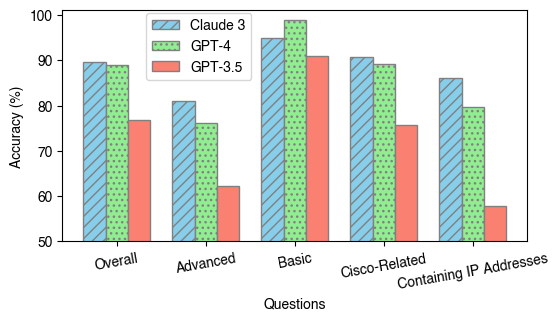

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [21]:
# def plot_with_matplotlib_all_three_types(claude3, gpt4, gpt35, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentages'):
def calculatePercentage(tuple_num_denom):
    return tuple_num_denom[0]*100/tuple_num_denom[1]

def createAccuracyGraph(inference = 0, detection=3, filename="performance.pdf"):
    claude3 = {}
    claude3["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Claude3", "all", inference, detection))
    claude3["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Claude3", "Grad", inference, detection))
    claude3["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Claude3", "Basic", inference, detection))
    claude3["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Claude3", "Cisco", inference, detection))
    claude3["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/IP/Claude3", "all", inference, detection))

    gpt4 = {}
    gpt4["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT4", "all", inference, detection))
    gpt4["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT4", "Grad", inference, detection))
    gpt4["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT4", "Basic", inference, detection))
    gpt4["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT4", "Cisco", inference, detection))
    gpt4["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/IP/GPT4", "all", 0, detection))

    gpt35 = {}
    gpt35["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "all", inference, detection))
    gpt35["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Grad", inference, detection))
    gpt35["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Basic", inference, detection))
    gpt35["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Cisco", inference, detection))
    gpt35["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/IP/GPT3.5", "all", inference, detection))

    plot_with_matplotlib_all_three_types(claude3, gpt4, gpt35, k=5, xlabel = 'Questions', ylabel='Accuracy (%)', rotation=10, legend_loc=(0.18,0.70), bar_width=0.25, figsize=(6,3), x_label_on=True, filename=filename)

createAccuracyGraph(filename="performance_accuracy.pdf")

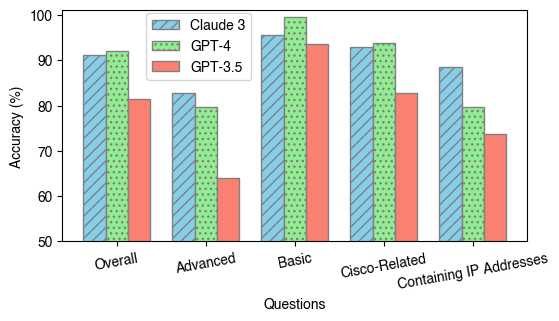

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [22]:
createAccuracyGraph(inference=1, filename="performance_inference.pdf") # inference with detailed reading

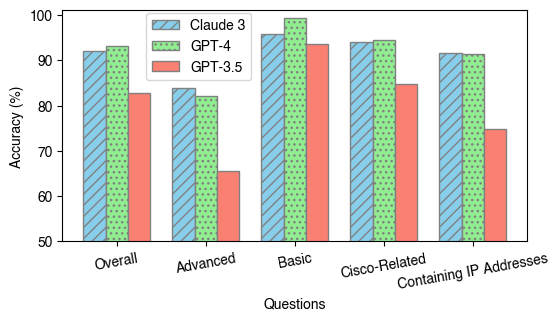

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [23]:
createAccuracyGraph(detection=2, filename="performance_detection.pdf")

### Graph with error bars

In [26]:
def plot_with_matplotlib_all_three_types_error_bars(
    claude3, gpt4, gpt35, k=4, xlabel='Misunderstanding Types', ylabel='Percentage (%)',
    rotation=45, legend_loc=0, min=50, labels=['Claude 3', 'GPT-4', 'GPT-3.5'],
    bar_width=0.25, figsize=(6, 2), filename="performance.pdf", x_label_on=True
):
    # Extracting words (keys)
    words = list(gpt35.keys())
    
    # Calculating means and standard deviations for each set
    def calc_mean_and_std(data):
        means = [np.mean(data[key]) for key in words]
        std_devs = [np.std(data[key]) for key in words]
        return means, std_devs

    claude3_means, claude3_std = calc_mean_and_std(claude3)
    gpt4_means, gpt4_std = calc_mean_and_std(gpt4)
    gpt35_means, gpt35_std = calc_mean_and_std(gpt35)

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(words))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Plotting word frequencies with error bars
    f = plt.figure(figsize=figsize)

    plt.bar(r1, claude3_means, yerr=claude3_std, color='skyblue', width=bar_width, 
            edgecolor='grey', label=labels[0], hatch='///', capsize=5)
    plt.bar(r2, gpt4_means, yerr=gpt4_std, color='lightgreen', width=bar_width, 
            edgecolor='grey', label=labels[1], hatch='...', capsize=5)
    plt.bar(r3, gpt35_means, yerr=gpt35_std, color='salmon', width=bar_width, 
            edgecolor='grey', label=labels[2], capsize=5)

    # Add xticks on the middle of the group bars
    if x_label_on:
        plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(words))], words, rotation=rotation)
    plt.ylim(min, 101)

    # Create legend & Show graphic
    if legend_loc == 0:
        plt.legend(loc="best")
    else:
        plt.legend(loc=legend_loc)
    # plt.title('Type of Misunderstandings')
    plt.show()
    if len(filename) > 1:
        f.savefig(filename, bbox_inches='tight')

# def plot_with_matplotlib_all_three_types(claude3, gpt4, gpt35, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentages'):
def calculatePercentage(tuple_num_denom):
    return tuple_num_denom[0]*100/tuple_num_denom[1]

def createAccuracyGraphErrorErrorBars(inference = 0, detection=3, num_inputs = 3, filename="performance.pdf"):
    claude3 = {}
    gpt4 = {}
    gpt35 = {}
    claude3["Overall"] = []
    claude3["Advanced"] = []
    claude3["Basic"] = []
    claude3["Cisco-Related"] = []
    claude3["Containing IP Addresses"] = []

    gpt4["Overall"] = []
    gpt4["Advanced"] = []
    gpt4["Basic"] = []
    gpt4["Cisco-Related"] = []
    gpt4["Containing IP Addresses"] = []

    gpt35["Overall"] = []
    gpt35["Advanced"] = []
    gpt35["Basic"] = []
    gpt35["Cisco-Related"] = []
    gpt35["Containing IP Addresses"] = []

    for i in range(num_inputs):
        j = i+1
        print(j)
        claude3["Overall"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/Claude3/{}".format(j), "all", inference, detection)))
        claude3["Advanced"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/Claude3/{}".format(j), "Grad", inference, detection)))
        claude3["Basic"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/Claude3/{}".format(j), "Basic", inference, detection)))
        claude3["Cisco-Related"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/Claude3/{}".format(j), "Cisco", inference, detection)))
        claude3["Containing IP Addresses"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/IP/Claude3/{}".format(j), "all", inference, detection)))

        gpt4["Overall"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT4/{}".format(j), "all", inference, detection)))
        gpt4["Advanced"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT4/{}".format(j), "Grad", inference, detection)))
        gpt4["Basic"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT4/{}".format(j), "Basic", inference, detection)))
        gpt4["Cisco-Related"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT4/{}".format(j), "Cisco", inference, detection)))
        gpt4["Containing IP Addresses"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/IP/GPT4/{}".format(j), "all", 0, detection)))

        gpt35["Overall"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT3.5/{}".format(j), "all", inference, detection)))
        gpt35["Advanced"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT3.5/{}".format(j), "Grad", inference, detection)))
        gpt35["Basic"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT3.5/{}".format(j), "Basic", inference, detection)))
        gpt35["Cisco-Related"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/GPT3.5/{}".format(j), "Cisco", inference, detection)))
        gpt35["Containing IP Addresses"].append(calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Multiple_runs/IP/GPT3.5/{}".format(j), "all", inference, detection)))

    plot_with_matplotlib_all_three_types_error_bars(claude3, gpt4, gpt35, k=5, xlabel = 'Questions', ylabel='Accuracy (%)', rotation=10, legend_loc=(0.18,0.70), bar_width=0.25, figsize=(6,3), x_label_on=True, filename=filename)

createAccuracyGraphErrorErrorBars(filename="performance_accuracy.pdf")

1


ParserError: Error tokenizing data. C error: Expected 47 fields in line 25, saw 48


## Detecting Errors (logprob and detection by students)
Human detection:
- Errors made by GPT4 and GPT3.5 are usually more easily detectable than Claude3 (e.g. Claude3 either makes more conceptual errors or is more convincing). If we remove questions that have detectable incorrect explanations: 
    -  Overall: All LLMs improve but GPT3.5 improves the most (a 6.2% increase)
    -  In all categories, the percentage gap between Claude3 and GPT4 decreases. This shows that in practice Claude3 and GPT4 might be similar in terms of potential harms

Confidence: (only for GPT4 and GPT3.5) (need help with this)
- Overall: The average confidence of answers for incorrect answers is much lower than for correct answers
    - GPT3.5 has low confidence when it makes conceptual recall errors
    - GPT4 has low confidence for both conceptual/informational recall errors and misinterpreted questions
    - Reasoning errors are harder to detect using confidence
- Overall: Errors that are detectable by humans are not necessarily the ones that LLMs are less confident aboutLLMs have almost the same amount of confidence on errors that are detectable by humans as errors that are not 
    - This might be good, since now we have two orthogonal ways to detect errors 
- Higher-level courses: GPT3.5 overall has less confidence in answers (i.e. is more unsure)

ECE Score:
- Overall: GPT4 (0.086) is better calibrated than GPT3.5 (0.169)
- Higher-Level Courses: Both GPT4 (0.192) and GPT3.5 (0.250) are poorly calibrated
- IP-related Questions: Both GPT4 (0.167) and GPT3.5 (0.349) are poorly calibrated

Logprob graphs: A way to find how to rely on model confidence to weed out potentially incorrect answers
- Overall: If we only consider questions with confidence 86% or higher, we retain 92.2% questions with around 92.2% accuracy

### Across all topics

In [ ]:
printRightMinusWrongScoresAllLLMs("results","all", detection=3)
print("\nResults if we remove incorrect questions that are quickly detectable")
printRightMinusWrongScoresAllLLMs("results","all", detection=1)
print("\nResults if we remove incorrect questions that are detectable with detailed reading")
printRightMinusWrongScoresAllLLMs("results","all", detection=2)

In [ ]:
print_all_logprob_detections("results","all")

In [ ]:
ECE_35 = calculateECE("Results/GPT3.5","all", bins=10)
print("ECE Score for GPT3.5:", round(ECE_35,3))
ECE_4 = calculateECE("Results/GPT4","all", bins=10)
print("ECE Score for GPT4:", round(ECE_4,3))

In [ ]:
x1, percentage_answers_retained1, accuracy1 = extract_logprob_points("Results/GPT3.5/","all", "GPT3.5")
x2, percentage_answers_retained2, accuracy2 = extract_logprob_points("Results/GPT4/","all", "GPT4")
plot_logprob(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2, filename="logprob.pdf")

### Higher-level Computer Networking Courses

In [ ]:
printRightMinusWrongScoresAllLLMs("results","Grad", detection=3)
print("\nResults if we remove incorrect questions that are quickly detectable")
printRightMinusWrongScoresAllLLMs("results","Grad", detection=1)
print("\nResults if we remove incorrect questions that are detectable with detailed reading")
printRightMinusWrongScoresAllLLMs("results","Grad", detection=2)

In [ ]:
print_all_logprob_detections("results","Grad")

In [ ]:
ECE_35 = calculateECE("Results/GPT3.5","Grad", bins=10)
print("ECE Score for GPT3.5:", round(ECE_35,3))
ECE_4 = calculateECE("Results/GPT4","Grad", bins=10)
print("ECE Score for GPT4:", round(ECE_4,3))

In [ ]:
x1, percentage_answers_retained1, accuracy1 = extract_logprob_points("Results/GPT3.5/","Grad", "GPT3.5")
x2, percentage_answers_retained2, accuracy2 = extract_logprob_points("Results/GPT4/","Grad", "GPT4")
plot_logprob(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2)

### Basic Computer Networking Courses

In [ ]:
printRightMinusWrongScoresAllLLMs("results","Basic", detection=3)
print("\nResults if we remove incorrect questions that are quickly detectable")
printRightMinusWrongScoresAllLLMs("results","Basic", detection=1)
print("\nResults if we remove incorrect questions that are detectable with detailed reading")
printRightMinusWrongScoresAllLLMs("results","Basic", detection=2)

In [ ]:
print_all_logprob_detections("results","Basic")

In [ ]:
ECE_35 = calculateECE("Results/GPT3.5","Basic", bins=10)
print("ECE Score for GPT3.5:", round(ECE_35,3))
ECE_4 = calculateECE("Results/GPT4","Basic", bins=10)
print("ECE Score for GPT4:", round(ECE_4,3))

In [ ]:
x1, percentage_answers_retained1, accuracy1 = extract_logprob_points("Results/GPT3.5/","Basic", "GPT3.5")
x2, percentage_answers_retained2, accuracy2 = extract_logprob_points("Results/GPT4/","Basic", "GPT4")
plot_logprob(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2)

### Cisco Related Computer Networking Courses

In [ ]:
printRightMinusWrongScoresAllLLMs("results","Cisco", detection=3)
print("\nResults if we remove incorrect questions that are quickly detectable")
printRightMinusWrongScoresAllLLMs("results","Cisco", detection=1)
print("\nResults if we remove incorrect questions that are detectable with detailed reading")
printRightMinusWrongScoresAllLLMs("results","Cisco", detection=2)

In [ ]:
print_all_logprob_detections("results","Cisco")

In [ ]:
ECE_35 = calculateECE("Results/GPT3.5","Cisco", bins=10)
print("ECE Score for GPT3.5:", round(ECE_35,3))
ECE_4 = calculateECE("Results/GPT4","Cisco", bins=10)
print("ECE Score for GPT4:", round(ECE_4,3))

In [ ]:
x1, percentage_answers_retained1, accuracy1 = extract_logprob_points("Results/GPT3.5/","Cisco", "GPT3.5")
x2, percentage_answers_retained2, accuracy2 = extract_logprob_points("Results/GPT4/","Cisco", "GPT4")
plot_logprob(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2)

### Questions related to IP

In [ ]:
printRightMinusWrongScoresAllLLMs("results/IP","all", detection=3)
print("\nResults if we remove incorrect questions that are quickly detectable")
printRightMinusWrongScoresAllLLMs("results/IP","all", detection=1)
print("\nResults if we remove incorrect questions that are detectable with detailed reading")
printRightMinusWrongScoresAllLLMs("results/IP","all", detection=2)

In [ ]:
print_all_logprob_detections("results/IP","all")

In [ ]:
ECE_35 = calculateECE("Results/IP/GPT3.5","all", bins=10)
print("ECE Score for GPT3.5:", round(ECE_35,3))
ECE_4 = calculateECE("Results/IP/GPT4","all", bins=10)
print("ECE Score for GPT4:", round(ECE_4,3))

In [ ]:
x1, percentage_answers_retained1, accuracy1 = extract_logprob_points("Results/IP/GPT3.5/","all", "GPT3.5")
x2, percentage_answers_retained2, accuracy2 = extract_logprob_points("Results/IP/GPT4/","all", "GPT4")
plot_logprob(x1, percentage_answers_retained1, accuracy1, x2, percentage_answers_retained2, accuracy2)

## Effects (Misconceptions and subtopics)
Notable Results:
- Overall: Although GPT3.5 has worse overall performance, its explanations are less likely to cause misconceptions compared to Claude3 and GPT4
- GPT3.5 makes a lot of errors related to basic networking concepts

### Across all topics

In [ ]:
printMisconceptions("Results/", "all")

In [ ]:
plot_all_llms_subtopics("Results/", "all")

In [ ]:
plot_all_llms_subtopics("Results/", "all", misconceptionsCheck=True, filename="effects_subtopics.pdf")

### Higher-level Computer Networking Courses

In [ ]:
printMisconceptions("Results/", "Grad")

In [ ]:
plot_all_llms_subtopics("Results/", "Grad")

### Basic Computer Networking Courses

In [ ]:
printMisconceptions("Results/", "Basic")

In [ ]:
plot_all_llms_subtopics("Results/", "Basic")

### Cisco Related Computer Networking Courses

In [ ]:
printMisconceptions("Results/", "Cisco")

In [ ]:
plot_all_llms_subtopics("Results/", "Cisco")

### Questions related to IP

In [ ]:
printMisconceptions("Results/IP", "all")

In [ ]:
plot_all_llms_subtopics("Results/IP", "all")

## Type of misunderstanding (primary types and reasons)
Notable results:
-  Overall: Most errors are based on information recall or concpetual issues. GPT4 is slightly better at conceptual/informational recall
-  High-level networking courses: GPT3.5 makes a high percentage of conceptual/informational recall errors (e.g. either GPT3.5 has not been exposed to the appropriate data or lacks the capability to recall rarer information)
-  Most of the mistakes that GPT4 and GPT3.5 make in IP related questions are related to incorrect handling of IP addresses

### Across all topics

In [ ]:
plot_all_llms_types(base="Results/", category="all", filename="misunderstanding_types.pdf")
plot_all_llms_reasons(base="Results/", category="all", k=3, ylim = 100)

### Higher-level Computer Networking Courses

In [ ]:
plot_all_llms_types(base="Results/", category="Grad")
plot_all_llms_reasons(base="Results/", category="Grad", k=4, ylim = 60)

### Basic Computer Networking Courses

In [ ]:
plot_all_llms_types(base="Results/", category="Basic")
plot_all_llms_reasons(base="Results/", category="Basic", k=4, ylim=10)

### Cisco Related Computer Networking Courses

In [ ]:
plot_all_llms_types(base="Results/", category="Cisco")
plot_all_llms_reasons(base="Results/", category="Cisco", k=4, ylim=40)

### Questions related to IP

In [ ]:
plot_all_llms_types(base="Results/IP", category="all")
plot_all_llms_reasons(base="Results/IP", category="all", k=4, ylim=17, filename="misunderstanding_reasons.pdf")

## Explainability (sources and explainability score)
Notable Results (Explainability):
- Overall: GPT3.5 (68.79%) scores low on explainability while GPT4 (91.25%) scores higher than Claude3 (84.51%)

Notable Results (Sources):
- Overall: Almost 1/3rd sources given by GPT4 and Claude3 are not working, and almost half are irrelevant
- Overall: GPT3.5 provides very limited sources
- Cisco: GPT4 (80.95%) provides much more working and relevant sources (maybe it does have cisco related documentation as part of its training set?)
- (Not shown): Claude3 mostly provided books as sources, while GPT4 provided direct links to articles, documentation, wikipedia links which might be more convenient


### Across all topics

In [ ]:
print_all_source_and_explainable_info("Results","all")

In [ ]:
plot_all_llms_sources("Results","all",k=4, filename="sources.pdf")

### Higher-level Computer Networking Courses

In [ ]:
print_all_source_and_explainable_info("Results","Grad")

In [ ]:
plot_all_llms_sources("Results","Grad",k=4)

### Basic Computer Networking Courses

In [ ]:
print_all_source_and_explainable_info("Results","Basic")

In [ ]:
plot_all_llms_sources("Results","Basic",k=4)

### Cisco Related Computer Networking Courses

In [ ]:
print_all_source_and_explainable_info("Results","Cisco")

In [ ]:
plot_all_llms_sources("Results","Cisco",k=4)

### Questions related to IP

In [ ]:
print_all_source_and_explainable_info("Results/IP","all")

# <b>Improvement strategies<b>

## Best of 2/3
Maybe also take into account the confidence i.e. if the confidence of current LLM is low, consult another LLM

In [ ]:
print("Overall")
calculate_best_out_of_3_score("results/","all")
print("\nHigh-level courses")
calculate_best_out_of_3_score("results/","Grad")
print("\nBasic courses")
calculate_best_out_of_3_score("results/","Basic")
print("\nCisco-related courses")
calculate_best_out_of_3_score("results/","Cisco")
print("\nIP Related")
calculate_best_out_of_3_score("results/IP","all")

In [ ]:
print("Overall")
printScoreDifferenceFromMajorityVoting("results/","all")
print("\nHigh-level courses")
printScoreDifferenceFromMajorityVoting("results/","Grad")
print("\nBasic courses")
printScoreDifferenceFromMajorityVoting("results/","Basic")
print("\nCisco-related courses")
printScoreDifferenceFromMajorityVoting("results/","Cisco")
print("\nIP Related")
printScoreDifferenceFromMajorityVoting("results/IP","all")

## Few-shot 

### Across all topics

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","all")
print("\nOne-shot scores:")
printRightMinusWrongScoresAllLLMs("Results/One-shot/","all")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/One-shot/", "all")

### Higher-level Computer Networking Courses

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","Grad")
print("\nOne-shot scores:")
printRightMinusWrongScoresAllLLMs("Results/One-shot/","Grad")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/One-shot/", "Grad")

### Basic Computer Networking Courses

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","Basic")
print("\nOne-shot scores:")
printRightMinusWrongScoresAllLLMs("Results/One-shot/","Basic")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/One-shot/", "Basic")

### Cisco Related Computer Networking Courses

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","Cisco")
print("\nOne-shot scores:")
printRightMinusWrongScoresAllLLMs("Results/One-shot/","Cisco")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/One-shot/", "Cisco")

### Questions related to IP

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/IP","all")
print("\nOne-shot scores:")
printRightMinusWrongScoresAllLLMs("Results/One-shot/IP","all")

In [ ]:
printRightMinusWrongScoresDifference("results/IP", "results/One-shot/IP", "all")

## Self-checking
Notable Results:
- Overall, self-checking actually degrades performance
- However, for questions based on IP addresses, performance improves significantly for both GPT4 (from 79.6% to 84.5%) and GPT3.5 (from 57.8% to 69.8%)

### Across all topics

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","all")
print("\nSelf-corrected scores:")
printRightMinusWrongScoresAllLLMs("results/self-correction/","all")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/self-correction/", "all")

### Higher-level Computer Networking Courses

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","Grad")
print("\nSelf-corrected scores:")
printRightMinusWrongScoresAllLLMs("results/self-correction/","Grad")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/self-correction/", "Grad")

### Basic Computer Networking Courses

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","Basic")
print("\nSelf-corrected scores:")
printRightMinusWrongScoresAllLLMs("results/self-correction/","Basic")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/self-correction/", "Basic")

### Cisco Related Computer Networking Courses

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/","Cisco")
print("\nSelf-corrected scores:")
printRightMinusWrongScoresAllLLMs("results/self-correction/","Cisco")

In [ ]:
printRightMinusWrongScoresDifference("results/", "results/self-correction/", "Cisco")

### Questions related to IP

In [ ]:
print("Old Scores:")
printRightMinusWrongScoresAllLLMs("results/IP","all")
print("\nSelf-corrected scores:")
printRightMinusWrongScoresAllLLMs("results/self-correction/IP","all")

In [ ]:
printRightMinusWrongScoresDifference("results/IP", "results/self-correction/IP", "all")

# <b>Correlations<b>

## Normal Answers
Notable Results:
- Overall there is little correlation between answers between the LLMs
- For Cisco related questions, there is moderate correlation between GPT3.5 and Claude3. This might hint on similar training data for Cisco related text

### Across all topics

In [ ]:
print_all_correlations_normal_case("Results","all")
print_all_contingency_tables_normal_case("Results","all")

### Higher-level Computer Networking Courses

In [ ]:
print_all_correlations_normal_case("Results","Grad")
print_all_contingency_tables_normal_case("Results","Grad")

### Basic Computer Networking Courses

In [ ]:
print_all_correlations_normal_case("Results","Basic")
print_all_contingency_tables_normal_case("Results","Basic")

### Cisco Related Computer Networking Courses

In [ ]:
print_all_correlations_normal_case("Results","Cisco")
print_all_contingency_tables_normal_case("Results","Cisco")

### Questions related to IP

In [ ]:
print_all_correlations_normal_case("Results/IP","all")
print_all_contingency_tables_normal_case("Results/IP","all")

## Randomized Choices (Robustness)
Notable Results: Note that this would depend on the temperature and the confidence
- Overall: Moderate (not high) correlations between original answers and answers with reordered choices

### Across all topics

In [ ]:
print_all_correlations_reordered_case("Results","Results/Reordered/","all")
print_all_contingency_tables_reordered_case("Results","Results/Reordered/","all")

In [ ]:
# Differences when temp=0
LLM1_correct, LLM2_correct, both_correct, both_incorrect = contingency_table("results/Temp_0/", "results/Temp_0_reordered/", "all")
matrix = [[both_correct,LLM2_correct],[LLM1_correct,both_incorrect]]
headers = ["GPT3.5 Correct","GPT3.5 Incorrect"]
index = ["GPT3.5 Reordered Correct","GPT3.5 Reordered Incorrect"]
num_ques = both_correct+LLM1_correct+LLM2_correct+both_incorrect
diff = LLM1_correct+LLM2_correct
print(tabulate(matrix, headers=headers, showindex=index))
print("Difference in {}/{} ({}%) questions".format(diff, num_ques, round(diff*100/num_ques,2)))

### Higher-level Computer Networking Courses

In [ ]:
print_all_correlations_reordered_case("Results","Results/Reordered/","Grad")
print_all_contingency_tables_reordered_case("Results","Results/Reordered/","Grad")

### Basic Computer Networking Courses

In [ ]:
print_all_correlations_reordered_case("Results","Results/Reordered/","Basic")
print_all_contingency_tables_reordered_case("Results","Results/Reordered/","Basic")

### Cisco Related Computer Networking Courses

In [ ]:
print_all_correlations_reordered_case("Results","Results/Reordered/","Cisco")
print_all_contingency_tables_reordered_case("Results","Results/Reordered/","Cisco")

### Questions related to IP

In [ ]:
print_all_correlations_reordered_case("Results/IP","Results/Reordered/IP","all")
print_all_contingency_tables_reordered_case("Results/IP","Results/Reordered/IP","all")

Discussion section
- Some sort of takeaways (e.g. lessons for teachers, lessons for future)
- Ways to leverage these tools? Possible ramifications without saying too binding
    - e.g. might be good to use multiple engines since they have some orthogonaly (similar to inversion programming)

## Open-source LLMs

In [ ]:
def plot_with_matplotlib_all_four_types(llm1, llm2, llm3, llm4, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentage (%)', rotation=45, legend_loc=0, min=50, labels=['Claude 3','GPT-4','GPT-3.5','llm4'], filename="open-source.pdf"):
    # Extracting words and their frequencies for each set of word frequencies
    words = list(llm1.keys())

    # Set the width of the bars
    bar_width = 0.2

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(words))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Plotting word frequencies side by side
    f = plt.figure(figsize=(7, 2))

    plt.bar(r1, list(llm1.values()), color='skyblue', width=bar_width, edgecolor='grey', label=labels[0], hatch= '///')
    plt.bar(r2, list(llm2.values()), color='lightgreen', width=bar_width, edgecolor='grey', label=labels[1],  hatch= '...')
    plt.bar(r3, list(llm3.values()), color='blue', width=bar_width, edgecolor='grey', label=labels[2], hatch= '***')
    plt.bar(r4, list(llm4.values()), color='salmon', width=bar_width, edgecolor='grey', label=labels[3])

    # Add xticks on the middle of the group bars
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(words))], words, rotation=rotation)
    plt.ylim(min, 101) 

    # Create legend & Show graphic
    if legend_loc == 0:
        plt.legend(loc="best")
    else:
        plt.legend(loc=legend_loc)
    # plt.title('Type of Misunderstandings')
    plt.show()
    f.savefig(filename, bbox_inches='tight')

# def plot_with_matplotlib_all_three_types(claude3, gpt4, gpt35, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentages'):
def createAccuracyGraphOpen(inference = 0, detection=3):
    mistral = {}
    mistral["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/mistral", "all", inference, detection))
    mistral["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/mistral", "Grad", inference, detection))
    mistral["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/mistral", "Basic", inference, detection))
    mistral["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/mistral", "Cisco", inference, detection))
    mistral["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/IP/mistral", "all", inference, detection))

    llama3 = {}
    llama3["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/llama3.1", "all", inference, detection))
    llama3["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/llama3.1", "Grad", inference, detection))
    llama3["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/llama3.1", "Basic", inference, detection))
    llama3["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/llama3.1", "Cisco", inference, detection))
    llama3["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/IP/llama3.1", "all", inference, detection))

    gemma2 = {}
    gemma2["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/gemma2", "all", inference, detection))
    gemma2["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/gemma2", "Grad", inference, detection))
    gemma2["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/gemma2", "Basic", inference, detection))
    gemma2["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/gemma2", "Cisco", inference, detection))
    gemma2["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/open-source/IP/gemma2", "all", 0, detection))

    gpt35 = {}
    gpt35["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "all", inference, detection))
    gpt35["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Grad", inference, detection))
    gpt35["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Basic", inference, detection))
    gpt35["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Cisco", inference, detection))
    gpt35["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/IP/GPT3.5", "all", inference, detection))

    plot_with_matplotlib_all_four_types(mistral, llama3, gemma2, gpt35, k=5, xlabel = 'Questions', ylabel='Accuracy (%)', rotation=10, legend_loc=(0.78,0.41), labels=["Mistral", "Llama-3.1", "Gemma2", "GPT-3.5"], min=30)

createAccuracyGraphOpen()

In [ ]:
## Difference Metrics

In [ ]:
import os
import sys
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Define the valid values for each column
valid_values = {
    "SM - Misunderstanding General": ["Wrong Facts/Concept", "Misinterpreting questions", "Incorrect reasoning/deduction"],
    "SM - Misunderstanding Reasons": ["Corner Case", "Out of date information", "Incorrect information/concept", "Quantifier issue", "Direct vs Indirect Causation", "Misinterpreting a word", "Incorrect copying of the question", "No explanation given", "Incorrect calculation or counting", "An error related to misinterpreting IP addresses", "Contradictory reasoning", "Senseless", "Faulty inference", "Self-aware but still wrong conclusion", "Incorrect Choice"],
    "AQ - Inferrable(0-2)?" : [0, 1, 2],
    # "AQ - Precise?" : [0, 1],
    "AQ - Explainable?" : [0, 1],
    "Effect - Conceptual error in explanaiton?(0/1)" : [0, 1],
    "CD - detection student(1-3)" : [1, 2, 3]
    # "CD - correction student(1-8)" : [1, 2, 3, 4, 5, 6, 7, 8],
    # "CD - detection knowledgeable(1-3)" : [1, 2, 3],
    # "CD - correction knowledgeable(1-8)" : [1, 2, 3, 4, 5, 6, 7, 8]
}

def load_and_concat_files(folder, valid_values):
    all_data = []
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            filepath = os.path.join(folder, filename)
            df = pd.read_csv(filepath)
            if df.empty:
                # print("Empty file. Skipping:", filename)
                continue
            # Add filename as a new column to ensure uniqueness when merging
            df['filename'] = filename
            
            # Only keep rows with valid "Question Number"
            df = df[df['Question Number'].notna()]
            
            # Convert float columns to int where necessary
            for column in valid_values.keys():
                if column in df.columns and pd.api.types.is_float_dtype(df[column]):
                    df[column] = df[column].astype(int)
                    # df[column] = df[column].astype(str)
            
            # Append the data to the list
            all_data.append(df)
    
    # Concatenate all data into a single DataFrame
    concatenated_df = pd.concat(all_data, ignore_index=True)
    
    return concatenated_df

def calculate_kappa_across_files(folder1, folder2, valid_values):
    # Load and concatenate all files from both folders
    df1 = load_and_concat_files(folder1, valid_values)
    df2 = load_and_concat_files(folder2, valid_values)

    
    # Merge on "Question Number" and "filename" to align the rows for comparison
    merged_df = pd.merge(df1, df2, on=["Question Number", "filename"], suffixes=('_1', '_2'))
    
    # Iterate through each column in the valid_values dictionary
    for column, valid in valid_values.items():
        col_1 = column + '_1'
        col_2 = column + '_2'
        if col_1 in merged_df.columns and col_2 in merged_df.columns:
            # Validate values in both columns
            df_valid = merged_df[merged_df[col_1].isin(valid) & merged_df[col_2].isin(valid)]
            # print(df_valid[col_1])
            # print(df_valid[col_2])
            # print(column)
            
            # Calculate Cohen's Kappa score
            kappa_score = cohen_kappa_score(df_valid[col_1], df_valid[col_2])
            print(f"Cohen's Kappa for '{column}': {kappa_score:.4f}")
        else:
            print(f"Warning: '{column}' column is missing in the merged data.")

In [ ]:
calculate_kappa_across_files("Results/Labels/Labeller1", "Results/Labels/Labeller2", valid_values)

## Fine-tuning

In [ ]:
def plot_with_matplotlib_all_four_types(llm1, llm2, llm3, llm4, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentage (%)', rotation=45, legend_loc=0, min=50, labels=['Claude 3','GPT-4','GPT-3.5','llm4'], filename="finetuned.pdf"):
    # Extracting words and their frequencies for each set of word frequencies
    words = list(llm1.keys())

    # Set the width of the bars
    bar_width = 0.2

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(words))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Plotting word frequencies side by side
    f = plt.figure(figsize=(7, 3))

    plt.bar(r1, list(llm1.values()), color='skyblue', width=bar_width, edgecolor='grey', label=labels[0], hatch= '///')
    plt.bar(r2, list(llm2.values()), color='lightgreen', width=bar_width, edgecolor='grey', label=labels[1],  hatch= '...')
    plt.bar(r3, list(llm3.values()), color='blue', width=bar_width, edgecolor='grey', label=labels[2], hatch= '***')
    plt.bar(r4, list(llm4.values()), color='salmon', width=bar_width, edgecolor='grey', label=labels[3])

    # Add xticks on the middle of the group bars
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(words))], words, rotation=rotation)
    plt.ylim(min, 101) 

    # Create legend & Show graphic
    if legend_loc == 0:
        plt.legend(loc="best")
    else:
        plt.legend(loc=legend_loc)
    # plt.title('Type of Misunderstandings')
    plt.show()
    f.savefig(filename, bbox_inches='tight')

# def plot_with_matplotlib_all_three_types(claude3, gpt4, gpt35, k=4, xlabel = 'Misunderstanding Types', ylabel='Percentages'):
def createAccuracyGraphFine(inference = 0, detection=3):
    large = {}
    large["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_full", "all", inference, detection))
    large["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_full", "Grad", inference, detection))
    large["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_full", "Basic", inference, detection))
    large["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_full", "Cisco", inference, detection))
    large["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/IP/Finetuned_full", "all", inference, detection))

    small = {}
    small["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_small", "all", inference, detection))
    small["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_small", "Grad", inference, detection))
    small["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_small", "Basic", inference, detection))
    small["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_small", "Cisco", inference, detection))
    small["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/IP/Finetuned_small", "all", inference, detection))

    ip_ft = {}
    ip_ft["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_ip", "all", inference, detection))
    ip_ft["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_ip", "Grad", inference, detection))
    ip_ft["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_ip", "Basic", inference, detection))
    ip_ft["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/Finetuned_ip", "Cisco", inference, detection))
    ip_ft["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/Finetuning_results/IP/Finetuned_ip", "all", 0, detection))

    gpt35 = {}
    gpt35["Overall"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "all", inference, detection))
    gpt35["Advanced"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Grad", inference, detection))
    gpt35["Basic"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Basic", inference, detection))
    gpt35["Cisco-Related"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/GPT3.5", "Cisco", inference, detection))
    gpt35["Containing IP Addresses"] = calculatePercentage(calculate_total_score_Right_minus_wrong("Results/IP/GPT3.5", "all", inference, detection))

    plot_with_matplotlib_all_four_types(ip_ft, small, large, gpt35, k=5, xlabel = 'Questions', ylabel='Accuracy (%)', rotation=10, legend_loc=(0.1,0.72), labels=["GPT-3.5-ft-ip", "GPT-3.5-ft-small", "GPT-3.5-ft-large", "GPT-3.5"], min=30)

createAccuracyGraphFine()